In [149]:
library(dplyr)      |> suppressPackageStartupMessages()
library(readr)      |> suppressPackageStartupMessages()
library(bnlearn)    |> suppressPackageStartupMessages()
library(bnstruct)   |> suppressPackageStartupMessages()
library(Rgraphviz)  |> suppressPackageStartupMessages()
library(foreach)    |> suppressPackageStartupMessages()
library(doParallel) |> suppressPackageStartupMessages()

## Functions

In [150]:
## Scoring function for exact results
scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = factorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      prod()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = prod(factorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) factorial(x + r - 1), r=r_i)
  num2 <- factorial(r_i - 1)

  return(prod(num2 / den * num1))
}

## Log scoring function to avoid numerical issues
log_scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = lfactorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      sum()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = sum(lfactorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) lfactorial(x + r - 1), r=r_i)
  num2 <- lfactorial(r_i - 1)

  return(sum(num1 - den + num2))
}

In [151]:
K2_algorithm <- function(data, max_parents){
  names <- colnames(data)
  results <- c()

  for (i in 1:ncol(data)){
    x_i <- names[i]
    parents <- c()
    p_old <- log_scoring_function(data, x_i, parents)
    proceed <- TRUE
    
    while (proceed){
      # Check if the maximum number of parents has been reached
      if (length(parents) >= max_parents){
        break
      }

      # Compute the predecessors
      predecessors <- setdiff(names[0:(i-1)], parents)
      if (length(predecessors) == 0){
        break
      }

      # Try adding a new parent
      scores <- sapply(predecessors, function(z) log_scoring_function(data, x_i, c(z, parents)))
      p_new <- max(scores)
      
      # If the score increases, add the parent
      if (p_new > p_old){
        p_old <- p_new
        parents <- c(parents, names[which.max(scores)])
      } else {
        proceed <- FALSE
      }
    } # end while
    
    results[[x_i]] <- parents
  } # end for

  return(list(names=names, parents_list=results))
}

In [152]:
# Convert the parent-child relationships to a DAG
get_dag <- function(names, parents_list){
  dag <- empty.graph(names)

  # Add arcs based on the parent-child relationships
  for (child in names) {
    parents <- parents_list[[child]]
    if (length(parents) > 0) {
      for (parent in parents) {
        dag <- set.arc(dag, from = parent, to = child)
      }
    }
  }
  return(dag)
}

In [153]:
K2_to_dag <- function(data, max_parents){
  # Run the K2 algorithm
  results <- K2_algorithm(data, max_parents)
  names <- results$names
  parents_list <- results$parents_list

  # Convert the parent-child relationships to a DAG
  dag <- get_dag(names, parents_list)

  # Get the score of the DAG
  score <- score(dag, data)

  return(list(dag=dag, score=score))
}

In [178]:
K2_pipeline <- function(data, max_parents, max_iter, mode="local", n_cores=-1){
  # Check if the mode is valid
  if (mode != "local" && mode != "parallel") {
    stop("Invalid mode. Please use 'local' or 'parallel'.")
  }
  
  # If the data does not have column names, assign them
  if (is.null(colnames(data))) {
    colnames(data) <- paste0("X", 1:ncol(data))
  }

  # Try different random orders of the columns
  if (mode == "local") {
    # Initialize the best score and DAG
    score_best <- -Inf
    dag_best <- NULL

    # Try different random orders of the columns
    for (i in 1:max_iter){
      data <- data |> select(sample(colnames(data)))
      result <- K2_to_dag(data, max_parents)
      score <- result$score

      # Update the best DAG
      if (score > score_best){
        score_best <- score
        dag_best <- result$dag
      }
    } 

    return(list(dag=dag_best, score=score_best))

  } else if (mode == "parallel") {
      # Setup parallel processing
      if (n_cores == -1) {
        n_cores <- detectCores()
      }
      cl <- makeCluster(n_cores)
      registerDoParallel(cl)

      # Try different random orders of the columns in parallel
      results <- mclapply(1:max_iter, function(i) {
        data_sampled <- data |> select(sample(colnames(data)))
        result <- K2_to_dag(data_sampled, max_parents)
        return(result)
      }, mc.cores = n_cores)

      # Initialize best score and DAG
      score_best <- -Inf
      dag_best <- NULL

      # Find the best result
      for (res in results) {
        if (res$score > score_best) {
          score_best <- res$score
          dag_best <- res$dag
        }
      }

      return(list(dag=dag_best, score=score_best))
    }

  return(NULL)
} 

## Ruiz dataset

In [179]:
records <- c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0)
ruiz_example  <- data.frame(matrix(records, 10,3, byrow=TRUE))

ruiz_example

X1,X2,X3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


In [180]:
print(scoring_function(ruiz_example, "X3", c()))
print(log_scoring_function(ruiz_example, "X3", c()))

[1] 0.0004329004


[1] -7.745003


In [182]:
res <- K2_pipeline(ruiz_example, max_parents=3, max_iter=3, mode="parallel")
print(paste("Score: ", res$score))

[1] "Score:  -23.3137121136653"


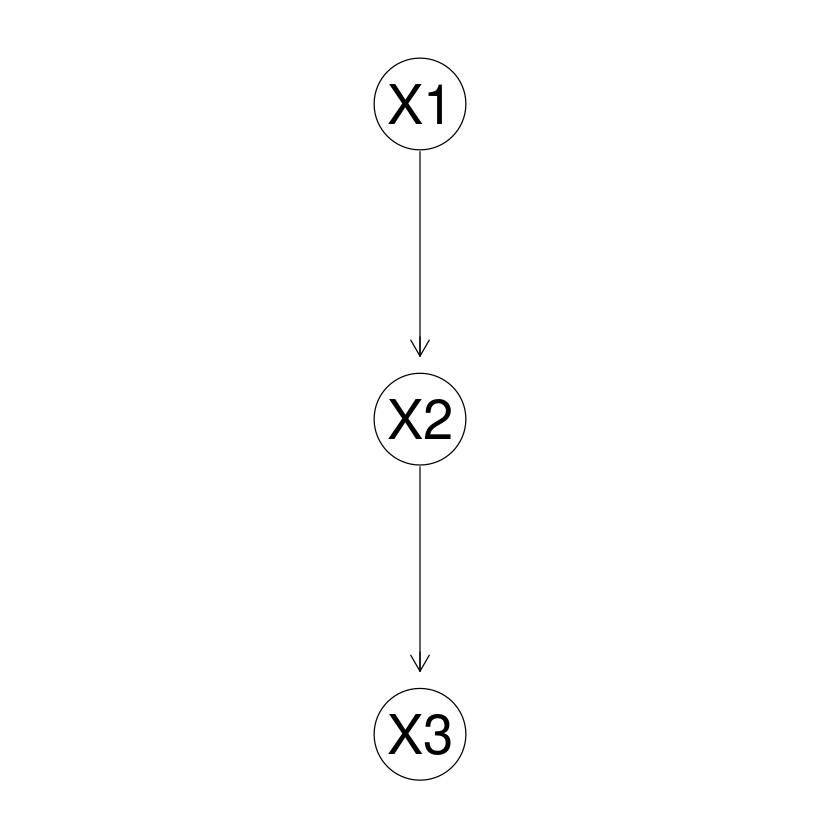

In [136]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

## Child dataset

In [140]:
# Load the data
child_df <- child() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(child_df) <- child()@variables
print(colnames(child_df))

head(child_df)

bnstruct :: performing imputation ...



bnstruct :: imputation finished.



 [1] "BirthAsphyxia"  "Disease"        "Age"            "LVH"           
 [5] "DuctFlow"       "CardiacMixing"  "LungParench"    "LungFlow"      
 [9] "Sick"           "HypDistrib"     "HypoxiaInO2"    "CO2"           
[13] "ChestXray"      "Grunting"       "LVHReport"      "LowerBodyO2"   
[17] "RUQO2"          "CO2Report"      "XrayReport"     "GruntingReport"


,BirthAsphyxia,Disease,Age,LVH,DuctFlow,CardiacMixing,LungParench,LungFlow,Sick,HypDistrib,HypoxiaInO2,CO2,ChestXray,Grunting,LVHReport,LowerBodyO2,RUQO2,CO2Report,XrayReport,GruntingReport
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,3,3,2,1,3,1,1,2,1,1,1,1,2,2,2,3,2,1,2
2,2,4,2,1,1,2,1,2,2,1,2,1,2,2,1,2,2,1,2,2
3,2,3,1,2,1,3,1,2,2,1,2,2,2,2,2,1,2,1,2,2
4,2,4,1,1,1,3,1,1,2,1,3,1,1,2,1,3,1,1,1,2
5,2,2,1,2,2,4,1,1,1,1,3,1,1,2,2,1,1,1,2,2
6,2,2,1,2,1,4,1,3,2,1,3,1,3,2,2,2,1,1,3,2


In [141]:
#res <- K2_to_dag(child_df, max_parents=3)
res <- K2_pipeline(child_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  -79692.5775684222"


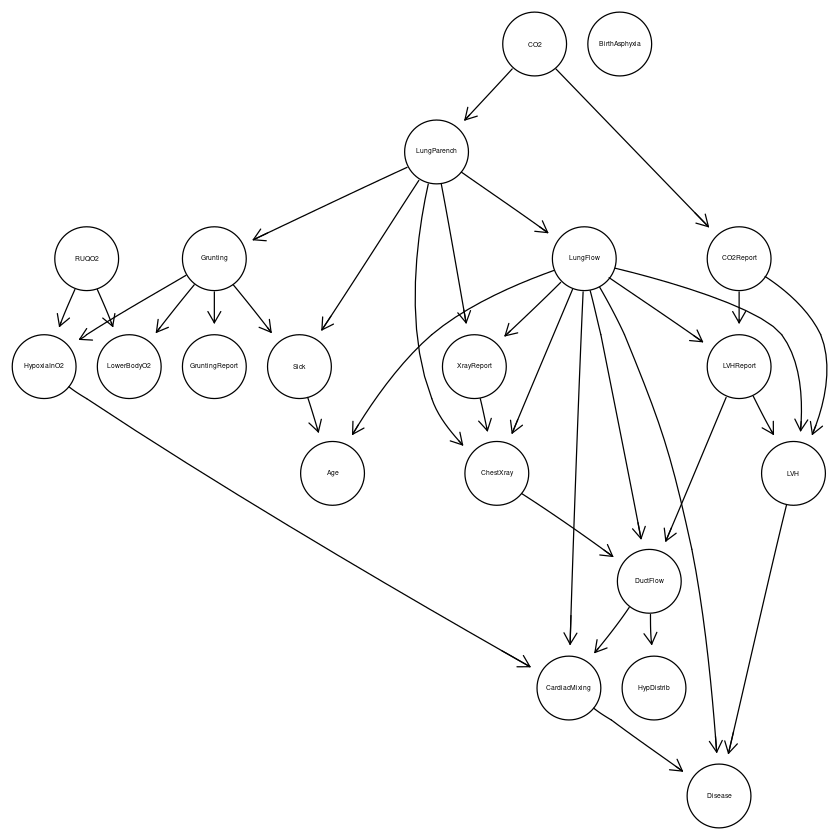

In [142]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

## Asia dataset

In [143]:
asia_df <- asia() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(asia_df) <- asia()@variables
print(colnames(asia_df))

head(asia_df)

bnstruct :: performing imputation ...



bnstruct :: imputation finished.



[1] "Asia"         "Tubercolosys" "Smoke"        "LungCancer"   "Bronchitis"  
[6] "Either"       "X-ray"        "Dyspnea"     


,Asia,Tubercolosys,Smoke,LungCancer,Bronchitis,Either,X-ray,Dyspnea
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,2,1,1,1,2,1,2
2,2,1,1,1,1,1,2,1
3,1,1,2,1,1,1,2,1
4,2,1,2,1,1,1,2,1
5,2,1,2,1,1,1,1,2
6,2,1,2,1,1,1,2,2


In [144]:
#res <- K2_to_dag(asia_df, max_parents=3)
res <- K2_pipeline(asia_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  26569.6856573522"


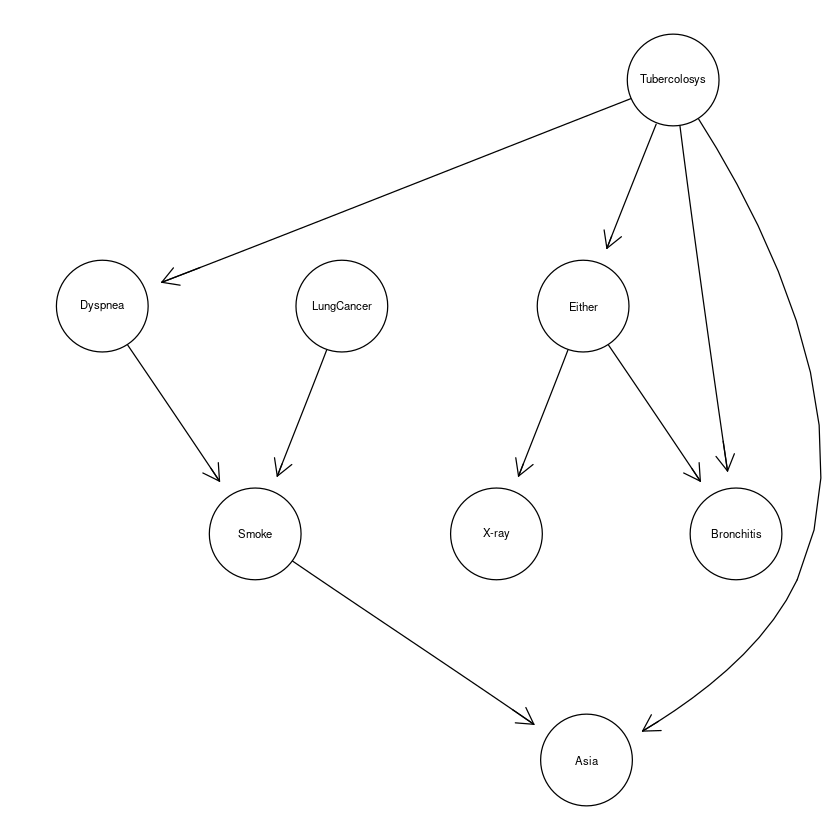

In [145]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

## SACHS

In [146]:
sachs_df <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv', show_col_types = FALSE)
head(sachs_df)

Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,1,1,2,2,3,1,1
1,2,1,1,2,1,2,2,2,1,1
1,1,3,1,3,2,2,1,1,3,3
1,2,1,1,1,1,3,3,1,1,2
1,2,1,1,1,1,3,2,2,2,1
1,2,2,2,1,1,1,2,2,1,2


In [147]:
#res <- K2_to_dag(sachs_df, max_parents=3)
res <- K2_pipeline(sachs_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  -94008.7185008838"


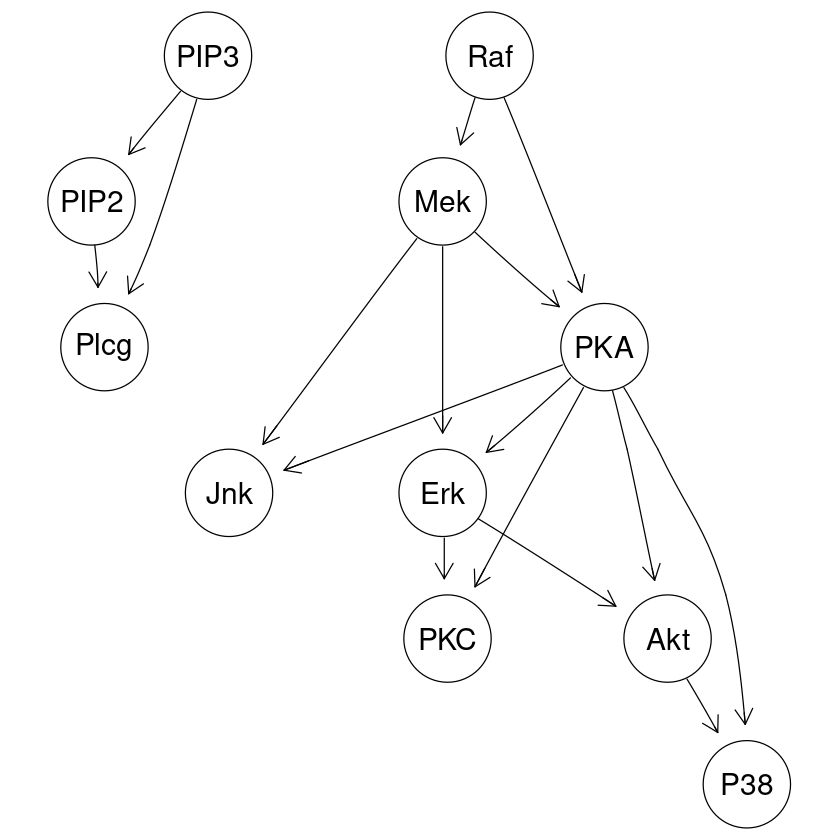

In [148]:
dag <- res$dag
graphviz.plot(dag, shape="circle")